In [1]:
import pandas as pd
from utils.constants import Paths

## Step 1: Reading data

In [2]:
user_df = pd.read_parquet(Paths.RAW_DATA_PARQUET / "user/pothole_311.parquet")

In [3]:
user_columns = [
    "Location",
    "Status",
    "Resolution Description",
    "Created Date",
    "Resolution Action Updated Date",
    "Street Name",
    "Cross Street 1",
    "Cross Street 2",
    "Intersection Street 1",
    "Intersection Street 2",
    "Address Type",
    "Incident Zip",
]

In [4]:
user_df = user_df[user_columns]

## Step 2: Processing Dataframe metadata

In [5]:
user_rename_map = {
    "Location": "geometry",
    "Status": "status",
    "Resolution Description": "resolution_description",
    "Created Date": "date_created",
    "Resolution Action Updated Date" : "date_closed",
    "Street Name": "street_name",
    "Cross Street 1": "cross_street_1",
    "Cross Street 2": "cross_street_2",
    "Intersection Street 1": "intersection_street_1",
    "Intersection Street 2": "intersection_street_2",
    "Address Type": "address_type",
    "Incident Zip": "zip_code",
}

user_df = user_df.rename(columns=user_rename_map)

In [6]:
user_df = user_df[~user_df['address_type'].isna()].dropna(subset=['geometry'])

In [7]:
user_df = user_df[user_df['status'] == "Closed"]
open_complaints_df = user_df[user_df['status'] != "Closed"]

user_df = user_df.drop(columns=["status"])

## Step 3: Cleaning Data

In [8]:
user_df['address_type'] = user_df['address_type'].replace('BLOCKFACE', 'ADDRESS')
user_df = user_df[user_df['address_type'] != 'PLACENAME']

Here we separate open and closed DataFrames, this is because the processing and grouping deals with response times

In [9]:
valid_complaint_strings = {
    "The Department of Transportation inspected this complaint and repaired the problem.",
    "The Department of Transportation has completed the request or corrected the condition.",
    "The Department of Transportation inspected the condition and temporary repairs were made to make the area safe. Permanent repairs/restoration will be scheduled as part of a project, seasonal work (April - November), or when work is assigned to a contractor.",
    "The Department of Transportation inspected this complaint and barricaded the area. The issue was referred to another unit for further action.",
}

In [10]:
user_df = user_df[user_df['resolution_description'].isin(valid_complaint_strings)]
user_df = user_df.drop(columns=['resolution_description'])

In [11]:
import numpy as np

In [12]:
user_df = user_df[~((user_df['address_type'] == 'ADDRESS') & (user_df['cross_street_1'].isnull() | user_df['cross_street_2'].isnull()))]

In [13]:
user_df = user_df[~((user_df['address_type'] == 'INTERSECTION') & (user_df['intersection_street_1'].isnull() | user_df['intersection_street_2'].isnull()))]

In [14]:
address_mask_user = user_df['address_type'] == 'ADDRESS'
user_df.loc[address_mask_user, 'street'] = user_df.loc[address_mask_user, 'street_name'] + ', ' + user_df.loc[address_mask_user, ['cross_street_1', 'cross_street_2']].apply(sorted, axis=1).str.join(', ')

In [15]:
intersection_mask_user = user_df['address_type'] == 'INTERSECTION'
user_df.loc[intersection_mask_user, 'street'] = user_df.loc[intersection_mask_user, ['intersection_street_1', 'intersection_street_2']].apply(sorted, axis=1).str.join(', ')

In [16]:
user_df['date_created'] = pd.to_datetime(user_df['date_created'])
user_df['date_closed'] = pd.to_datetime(user_df['date_closed'])

In [17]:
user_df["response_time"] = (user_df["date_closed"] - user_df["date_created"]).dt.days
user_df = user_df[user_df["response_time"] >= 0]

## Step 4: Counting duplicate complaints

In [18]:
user_df = user_df.sort_values(['date_created','street'])
user_df['num_requests'] = 0

In [19]:
from pandas import Timedelta

In [20]:
sampled_df = user_df.sample(frac=1)

In [21]:
# fast
res_df = pd.DataFrame()
cnt = 0
for zip_code in sampled_df['zip_code'].unique():
    cnt += 1
    print("\r",end=f"{cnt}/{len(sampled_df['zip_code'].unique())}")
    group = sampled_df[sampled_df['zip_code'] == zip_code]
    group = group.reset_index(drop=True)

    for i in range(len(group) - 1):
        if group.at[i, 'num_requests'] < 0:
            continue

        count = 0
        
        for j in range(i + 1, len(group)):
            if (group.iloc[j]['street'] == group.iloc[i]['street'] and
                group.iloc[j]['date_created'] <= (group.iloc[i]['date_closed'] + Timedelta(1, unit='D'))):
                count += 1
                group.at[j, 'num_requests'] = -1
            else:
                break
        group.at[i, 'num_requests'] = count
    
    res_df = pd.concat([res_df, group])

235/235

In [22]:
# # slow
# cnt = 0
# for index, record in sampled_df.iterrows():
#     cnt+=1
#     print("\r",end=f"{cnt}/{len(sampled_df)}")
#     sampled_df.at[index, 'num_requests'] = len(sampled_df[
#         (sampled_df['street']==record['street']) &
#         (sampled_df['date_created']>=record['date_created']) &
#         (sampled_df['date_created']<=record['date_closed'])
#     ])

In [23]:
sample_percentage = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
processing_time_slow = [2.6, 40.4, 172.3, 718.216, 4613.2, 18628.856]
processing_time_fast = [0.4, 2.2, 4.2, 8.6, 21.4, 43.5] 

In [24]:
def eq(x):
    return 2.556-(183.7*x)+(18810**2)

In [25]:
processing_time_slow_minutes = [i/60 for i in processing_time_slow]
processing_time_fast_minutes = [i/60 for i in processing_time_fast]

In [26]:
import matplotlib.pyplot as plt

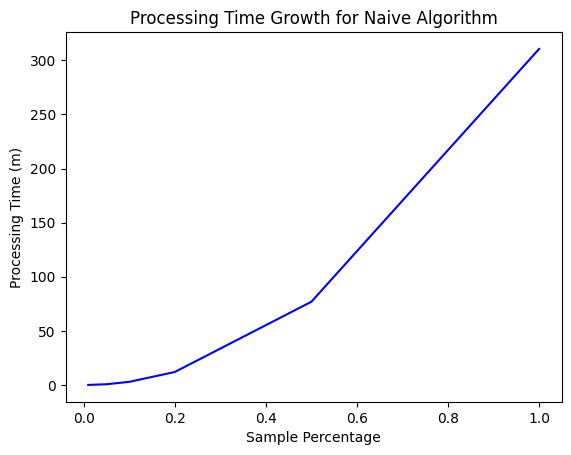

In [27]:
plt.plot(sample_percentage, processing_time_slow_minutes, label='Slow', color='b')
plt.xlabel('Sample Percentage')
plt.ylabel('Processing Time (m)')
plt.title('Processing Time Growth for Naive Algorithm')
plt.show()

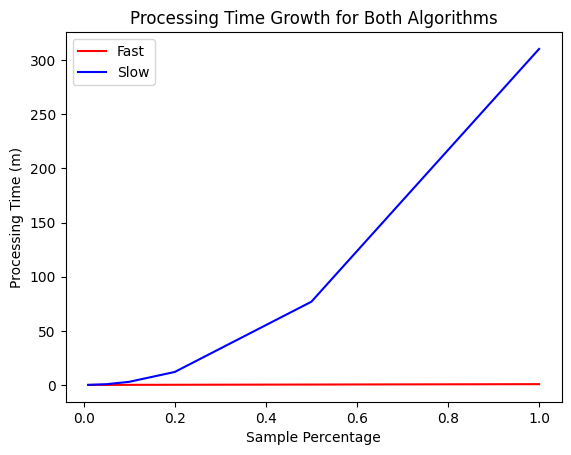

In [28]:
plt.plot(sample_percentage, processing_time_fast_minutes, label='Fast', color='r')
plt.plot(sample_percentage, processing_time_slow_minutes, label='Slow', color='b')
plt.xlabel('Sample Percentage')
plt.ylabel('Processing Time (m)')
plt.title('Processing Time Growth for Both Algorithms')
plt.legend()
plt.show()

## Step 5: Adding geographic data

In [29]:
import geopandas as gpd
import ast
from shapely.geometry import Point
from shapely import wkt

In [30]:
res_df['geometry'] = res_df['geometry'].apply(lambda loc: (lambda y, x: Point(x, y))(*ast.literal_eval(loc)))
open_complaints_df['geometry'] = open_complaints_df['geometry'].apply(lambda loc: (lambda y, x: Point(x, y))(*ast.literal_eval(loc)))

In [31]:
res_gdf = gpd.GeoDataFrame(res_df, geometry='geometry', crs='EPSG:4326')

## Step 5a: Adding street pavement ratings

In [32]:
rating_df = pd.read_csv(Paths.RAW_DATA_CSV / "nyc_pavement_ratings.csv")

In [34]:
rating_column_mapping = {
    "the_geom" : "geometry",
    "RatingDate": "rating_date",
    "Rating_B": "rating",
    "Length" : "street_length",
}
rating_df = rating_df.rename(columns=rating_column_mapping)[list(rating_column_mapping.values())]

In [35]:
rating_df['rating_date'] = pd.to_datetime(rating_df['rating_date'])

/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_75081/3384330031.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rating_df['rating_date'] = pd.to_datetime(rating_df['rating_date'])


In [36]:
rating_df['geometry'] = rating_df['geometry'].apply(wkt.loads)
rating_gdf = gpd.GeoDataFrame(rating_df, geometry='geometry', crs='EPSG:4326')

In [37]:
res_gdf = res_gdf.to_crs(epsg=3857)
rating_gdf = rating_gdf.to_crs(epsg=3857)

In [38]:
#res_gdf = res_gdf.drop(columns=['rating_date', 'rating', 'point_id', 'time_difference'])

In [39]:
rating_311_gdf = gpd.sjoin_nearest(res_gdf, rating_gdf, how='inner').drop(columns=['index_right'])

In [40]:
rating_311_gdf['time_difference'] = (rating_311_gdf['date_created'] - rating_311_gdf['rating_date']).abs()
max_time_diff = pd.Timedelta(days=300)
rating_311_gdf = rating_311_gdf[rating_311_gdf['time_difference'] <= max_time_diff]

rating_311_gdf['point_id'] = range(len(rating_311_gdf))
idx = rating_311_gdf.groupby('point_id')['time_difference'].idxmin()
rating_311_gdf = rating_311_gdf.loc[idx]

## Step 6: Adding census data

In [41]:
census_df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "census_data.parquet")

In [42]:
from shapely import wkt

census_df['geometry'] = census_df['geometry'].apply(wkt.loads)

In [43]:
census_gdf = gpd.GeoDataFrame(census_df, geometry='geometry', crs='EPSG:4326')

Calculate population density

In [44]:
census_gdf = census_gdf.to_crs(epsg=32633)

census_gdf['population'] = census_gdf['population'].str.replace(',','').astype(int)

census_gdf['area'] = census_gdf['geometry'].area / 1e6  # convert from square meters to square kilometers
census_gdf['population_density'] = census_gdf['population'].astype(float) / census_gdf['area']

In [45]:
census_gdf = census_gdf.to_crs(epsg=4326)

In [46]:
census_gdf = census_gdf.to_crs(epsg=3857)
rating_311_gdf = rating_311_gdf.to_crs(epsg=3857)

In [47]:
len(census_gdf)

2324

In [48]:
# join results with census, the point in results_gdf needs to be within the_geom polygon in census_gdf, needs to be inner join

results_census_gdf = gpd.sjoin(rating_311_gdf, census_gdf, how="inner", predicate="within")
print(results_census_gdf[results_census_gdf.is_valid])
#len(results_census_gdf)

                              geometry        date_created  \
131   POINT (-8232638.935 4978965.989) 2021-02-26 14:33:01   
53    POINT (-8232851.488 4979083.505) 2021-06-30 13:39:23   
720   POINT (-8232763.894 4979035.448) 2021-01-29 22:40:45   
889   POINT (-8232763.894 4979035.448) 2021-02-16 10:50:04   
710   POINT (-8232762.833 4978744.956) 2021-04-09 23:01:13   
...                                ...                 ...   
1432  POINT (-8229953.794 4963085.381) 2021-01-25 13:01:11   
1432  POINT (-8229953.794 4963085.381) 2021-01-25 13:01:11   
1432  POINT (-8229953.794 4963085.381) 2021-01-25 13:01:11   
1432  POINT (-8229953.794 4963085.381) 2021-01-25 13:01:11   
4961  POINT (-8238272.549 4960791.013) 2020-05-19 14:02:10   

             date_closed       street_name    cross_street_1  \
131  2021-02-26 23:36:00              None              None   
53   2021-07-01 12:17:00  EAST   79 STREET          2 AVENUE   
720  2021-02-04 01:35:00  EAST   79 STREET          2 AVENUE   

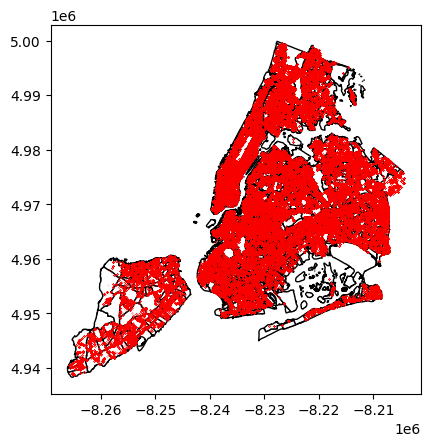

In [49]:
fig, ax = plt.subplots()

census_gdf.plot(ax=ax, color='white', edgecolor='black')

rating_311_gdf.plot(ax=ax, color='red', markersize=0.01)

plt.show()

In [50]:
len(rating_311_gdf)

562062

In [51]:
cols_to_drop = [
    'cross_street_1',
    'cross_street_2',
    'intersection_street_1',
    'intersection_street_2',
    'address_type',
    'point_id',
    'index_right',
    'area'
]

In [52]:
results_census_gdf = results_census_gdf.drop(columns=cols_to_drop)

In [53]:
results_census_gdf

,geometry,date_created,date_closed,street_name,zip_code,street,response_time,num_requests,rating_date,rating,...,median_income_native,median_income_asian,median_income_pacific_islander,median_income_other,median_income_two_plus,median_income_white,median_income_hispanic,neighborhood,borough,population_density
131,POINT (-8232638.935 4978965.989),2021-02-26 14:33:01,2021-02-26 23:36:00,None,10075,"2 AVENUE, EAST 79 STREET",0,0,2020-10-03,7,...,NaN,NaN,NaN,NaN,250001.0,144972.0,68713.0,Upper East Side-Lenox Hill-Roosevelt Island,Manhattan,28052.595936
53,POINT (-8232851.488 4979083.505),2021-06-30 13:39:23,2021-07-01 12:17:00,EAST 79 STREET,10075,"EAST 79 STREET, 2 AVENUE, 3 AVENUE",0,0,2021-07-31,7,...,NaN,NaN,NaN,NaN,250001.0,144972.0,68713.0,Upper East Side-Lenox Hill-Roosevelt Island,Manhattan,28052.595936
720,POINT (-8232763.894 4979035.448),2021-01-29 22:40:45,2021-02-04 01:35:00,EAST 79 STREET,10075,"EAST 79 STREET, 2 AVENUE, 3 AVENUE",5,1,2021-07-31,7,...,NaN,NaN,NaN,NaN,250001.0,144972.0,68713.0,Upper East Side-Lenox Hill-Roosevelt Island,Manhattan,28052.595936
889,POINT (-8232763.894 4979035.448),2021-02-16 10:50:04,2021-02-16 23:54:00,EAST 79 STREET,10075,"EAST 79 STREET, 2 AVENUE, 3 AVENUE",0,0,2021-07-31,7,...,NaN,NaN,NaN,NaN,250001.0,144972.0,68713.0,Upper East Side-Lenox Hill-Roosevelt Island,Manhattan,28052.595936
710,POINT (-8232762.833 4978744.956),2021-04-09 23:01:13,2021-04-10 15:00:00,2 AVENUE,10075,"2 AVENUE, EAST 76 STREET, EAST 77 STREET",0,0,2020-10-03,7,...,NaN,NaN,NaN,NaN,250001.0,144972.0,68713.0,Upper East Side-Lenox Hill-Roosevelt Island,Manhattan,28052.595936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,POINT (-8229953.794 4963085.381),2021-01-25 13:01:11,2021-01-26 11:40:00,CROWN STREET,11213,"CROWN STREET, FORD STREET, UTICA AVENUE",0,0,2021-06-08,9,...,NaN,NaN,NaN,NaN,NaN,NaN,31250.0,Crown Heights (South),Brooklyn,15338.391528
1432,POINT (-8229953.794 4963085.381),2021-01-25 13:01:11,2021-01-26 11:40:00,CROWN STREET,11213,"CROWN STREET, FORD STREET, UTICA AVENUE",0,0,2021-06-08,9,...,NaN,NaN,NaN,NaN,NaN,NaN,31250.0,Crown Heights (South),Brooklyn,15338.391528
1432,POINT (-8229953.794 4963085.381),2021-01-25 13:01:11,2021-01-26 11:40:00,CROWN STREET,11213,"CROWN STREET, FORD STREET, UTICA AVENUE",0,0,2021-06-08,9,...,NaN,NaN,NaN,NaN,NaN,NaN,31250.0,Crown Heights (South),Brooklyn,15338.391528
1432,POINT (-8229953.794 4963085.381),2021-01-25 13:01:11,2021-01-26 11:40:00,CROWN STREET,11213,"CROWN STREET, FORD STREET, UTICA AVENUE",0,0,2021-06-08,9,...,NaN,NaN,NaN,NaN,NaN,NaN,31250.0,Crown Heights (South),Brooklyn,15338.391528


## Step 7: Visualization

In [54]:
import matplotlib.colors as colors
from tabulate import tabulate

In [55]:
hexbin_plot_gdf = results_census_gdf.to_crs(epsg=3857)

In [56]:
vmin, vmax = np.percentile(hexbin_plot_gdf['response_time'], [5, 95])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

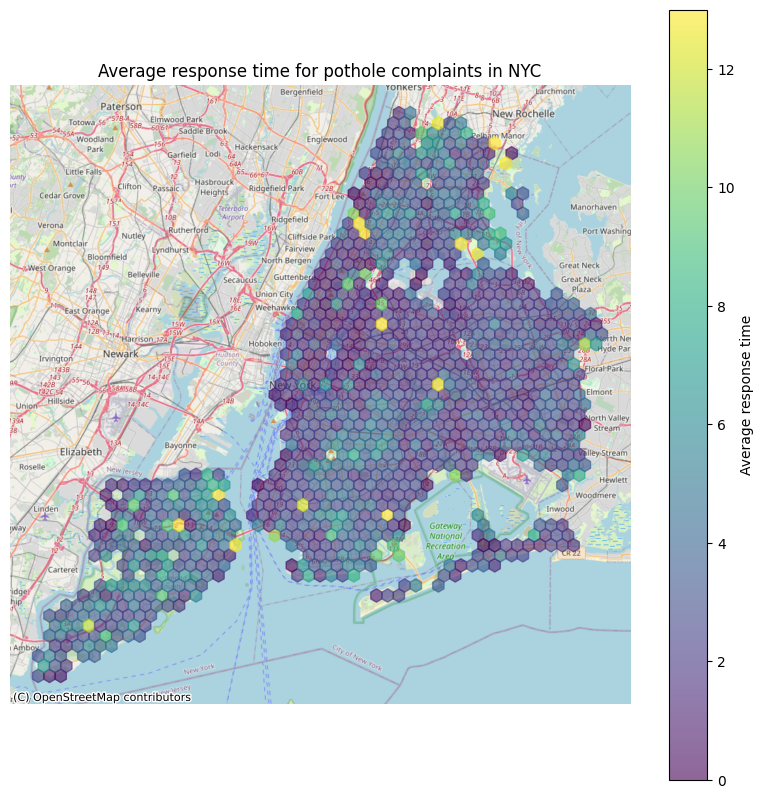

In [57]:
import contextily as ctx
import matplotlib.pyplot as plt

tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = hexbin_plot_gdf.geometry.x
y = hexbin_plot_gdf.geometry.y

hb = ax.hexbin(x, y, C=hexbin_plot_gdf['response_time'], gridsize=50, reduce_C_function=np.mean, cmap='viridis', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Average response time')

# Add the basemap
ctx.add_basemap(ax, crs=hexbin_plot_gdf.crs.to_string(), source=tile_provider)

plt.title('Average response time for pothole complaints in NYC')
plt.axis('off')
plt.show()

In [58]:
import contextily as ctx
import matplotlib.pyplot as plt

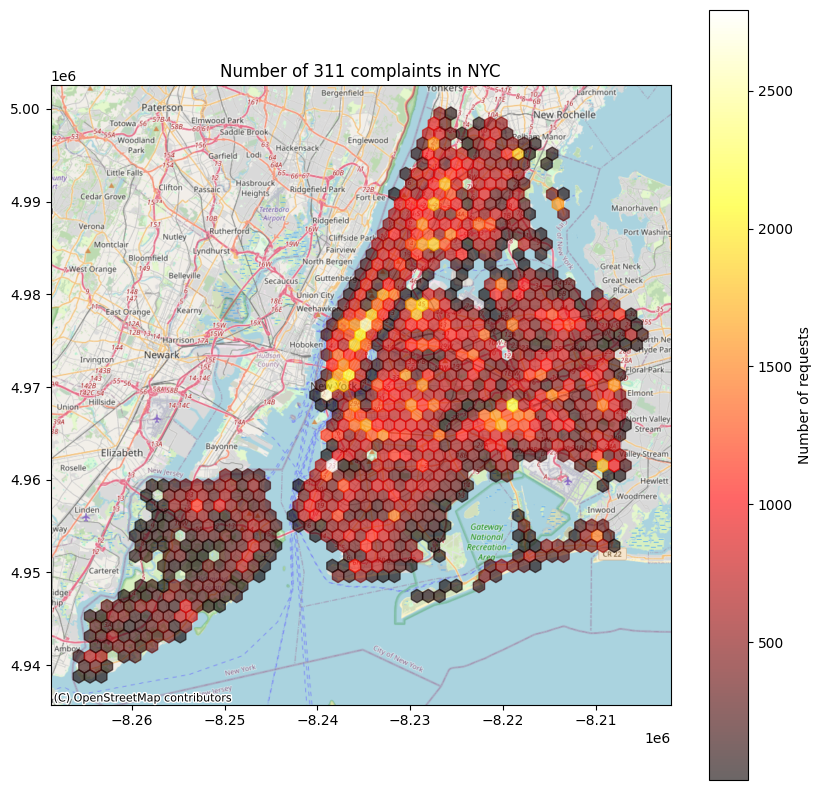

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))

# Group the data by location and count the number of requests
grouped_gdf = hexbin_plot_gdf.groupby(['geometry']).size().reset_index(name='num_requests')
grouped_gdf.crs = hexbin_plot_gdf.crs

tile_provider = ctx.providers.OpenStreetMap.Mapnik

# Get the x and y coordinates
x = grouped_gdf.geometry.apply(lambda geom: geom.x)
y = grouped_gdf.geometry.apply(lambda geom: geom.y)

# Create the hexbin plot
hb = ax.hexbin(x, y, C=grouped_gdf['num_requests'], gridsize=50, reduce_C_function=np.sum, cmap='hot', alpha=0.6)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of requests')

# Add the basemap
ctx.add_basemap(ax, crs=grouped_gdf.crs.to_string(), source=tile_provider)

plt.title('Number of 311 complaints in NYC')
plt.show()

In [60]:
print(tabulate(results_census_gdf.sort_values(by="num_requests",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+-----------------------------------------------+---------------------+---------------------+------------------+------------+-------------------------------------------------+-----------------+----------------+---------------------+----------+-----------------+-------------------+-------------+--------------+-----------+--------------+----------------+----------------+----------------+----------------+----------------+-------------------+-------------------+--------------------+----------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+------------------------+-----------------------+----------------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-------------------------+-----------+----------------------+
| geometry                                      | date_created        | date_closed         | street_name      |   zip_code | street

In [61]:
results_census_gdf.columns

Index(['geometry', 'date_created', 'date_closed', 'street_name', 'zip_code',
       'street', 'response_time', 'num_requests', 'rating_date', 'rating',
       'street_length', 'time_difference', 'geo_id', 'population', 'bct_num',
       'median_age', 'hispanic_pct', 'white_nh_pct', 'black_nh_pct',
       'asian_nh_pct', 'other_nh_pct', 'two_plus_nh_pct', 'average_hh_size',
       'less_than_hs_pct', 'hs_pct', 'some_college_pct',
       'associate_degree_pct', 'bachelors_or_higher_pct',
       'median_household_income', 'median_income_black',
       'median_income_native', 'median_income_asian',
       'median_income_pacific_islander', 'median_income_other',
       'median_income_two_plus', 'median_income_white',
       'median_income_hispanic', 'neighborhood', 'borough',
       'population_density'],
      dtype='object')

In [62]:
results_census_gdf['geometry'] = results_census_gdf['geometry'].apply(lambda geom: geom.wkt)
results_census_gdf.to_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_pothole.parquet")
results_census_gdf.to_csv(Paths.PROCESSED_DATA_CSV / "aggregated_pothole.csv", index=False)

/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_75081/2920354261.py:1: UserWarning: Geometry column does not contain geometry.
  results_census_gdf['geometry'] = results_census_gdf['geometry'].apply(lambda geom: geom.wkt)
